In [1]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [2]:
from utils import helper_functions as hf
from utils import change_detection as cd
import Config as Config

In [3]:
files_in_anomaly_directory = os.listdir(Config.ANOMALY_VIDEO_DIRECTORY)
anomaly_video_file = random.choice(files_in_anomaly_directory)
anomaly_video_file_path = os.path.join(Config.ANOMALY_VIDEO_DIRECTORY, anomaly_video_file)
anomaly_video_file_path

'./videos/Anomaly Videos/Vandalism019_x264.mp4'

In [4]:
anomaly_video_file_path = Config.TO_PROCESS_VIDEO_FILE_PATH
anomaly_video_file_path

'./videos/test videos/Anomaly Videos/Robbery056_x264.mp4'

In [5]:
model = tf.keras.models.load_model(Config.FINE_TUNED_LSTM_AUTO_ENCODER_PATH)

2023-08-13 15:32:22.521876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
#Extracting all the frames
video_frames_dict = hf.get_frames_from_video(anomaly_video_file_path)

In [7]:
len(video_frames_dict)

2761

In [8]:
frames_in_batches = hf.get_frames_in_batches(30, video_frames_dict)

In [9]:
frame_sequence_tracker = hf.get_frame_sequence_tracker(frames_in_batches)

In [10]:
len(frame_sequence_tracker)

92

In [11]:
frame_sequence_tracker[1].shape

(30, 256, 256, 1)

In [12]:
significant_keys = cd.perform_change_detection(frame_sequence_tracker)

In [13]:
len(significant_keys)

29

In [26]:
#Testing the logic of comparison with insignificant frames
# insignificant_keys = []


# for k in range(1, significant_keys[0]):
#     if k not in significant_keys:
#         insignificant_keys.append(k)
#         break
# if len(insignificant_keys) == 0:
#     print('Empty Insignificant Key')
#     for k in range(1, significant_keys[-1]):
#         if k not in significant_keys:
#             insignificant_keys.append(k)
#             break

In [14]:
insignificant_keys = hf.get_insignificant_frame(significant_keys)  

In [15]:
insignificant_keys

[4]

In [17]:
        
#Checking the prediction value of insignificant frame
insig_cost_tracker = {}

for key in insignificant_keys:
    insignificant_sequence = frame_sequence_tracker[insignificant_keys[0]]
    reshaped_insignificant_sequences = insignificant_sequence.reshape(3, 10, 256, 256, 1)

    for index, single_sequence in enumerate(reshaped_insignificant_sequences):
            single_sequence = np.expand_dims(single_sequence, axis=0)
            reconstructed_sequence = model.predict(single_sequence)  

            # Calculating reconstruction cost for the single sequence
            # cost = np.linalg.norm(single_sequence - reconstructed_sequence[0])
            cost = hf.get_reconstruction_cost(single_sequence, reconstructed_sequence)
            insig_cost_tracker[f'{key}_{index}'] = cost

1/1 [==============================] - 0s 27ms/step


In [18]:
insig_cost_tracker

{'4_0': 68.2987, '4_1': 69.54286, '4_2': 71.5471}

In [19]:
# def get_max_from_cost_dict(cost_dict):
#     max = 0
    
#     for key, value in cost_dict.items():
#         if value > max:
#             max = value
#     return max

In [20]:
# def get_anomaly_threshold_from_normal_cost(cost):
#     five_percent_cost = 0.05 * cost
#     anomaly_threshold = five_percent_cost + cost
#     return anomaly_threshold    

In [21]:
max_insignificant_prediction_score = hf.get_max_from_cost_dict(insig_cost_tracker)

In [23]:
max_insignificant_prediction_score

71.5471

In [25]:
anomaly_threshold = hf.get_anomaly_threshold_from_normal_cost(max_insignificant_prediction_score)
anomaly_threshold

75.12445106506348

In [26]:
cost_tracker = {}
for key in significant_keys:
    significant_sequence = frame_sequence_tracker[key]
    reshaped_sequences = significant_sequence.reshape(3, 10, 256, 256, 1)
    for index, single_sequence in enumerate(reshaped_sequences):
        single_sequence = np.expand_dims(single_sequence, axis=0)
        reconstructed_sequence = model.predict(single_sequence)  
        
        # Calculating reconstruction cost for the single sequence
        cost = np.linalg.norm(single_sequence - reconstructed_sequence[0])
        cost_tracker[f'{key}_{index}'] = cost


1/1 [==============================] - 0s 26ms/step


In [27]:
insignificant_keys

[4]

In [28]:
keys_to_consider = set() #Defining as a set to avoid duplicates

In [29]:
len(cost_tracker)

87

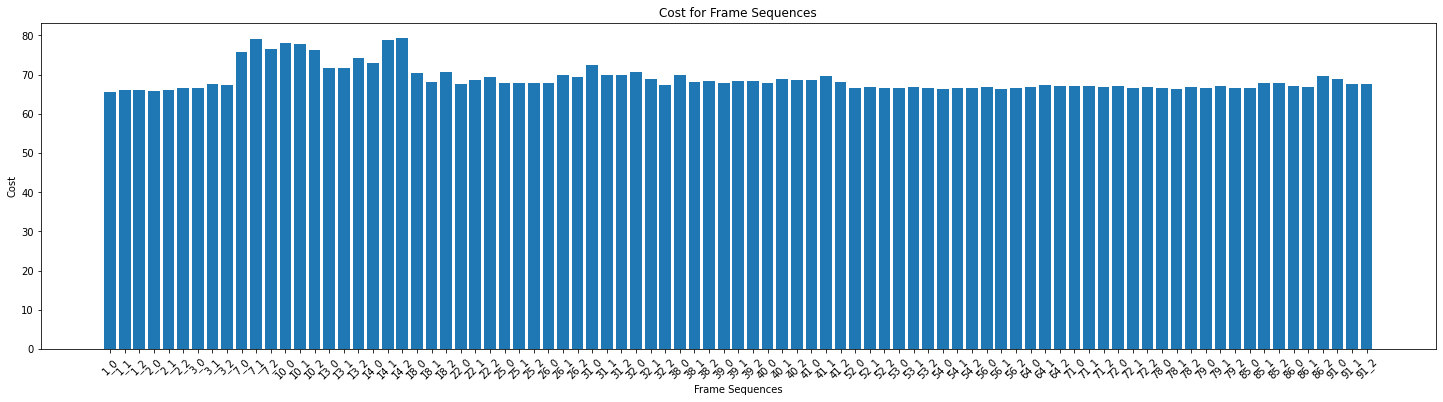

In [30]:
keys = list(cost_tracker.keys())
values = list(cost_tracker.values())

# Plotting
plt.figure(figsize=(25, 6))
plt.bar(keys, values)
plt.xlabel('Frame Sequences')
plt.ylabel('Cost')
plt.title('Cost for Frame Sequences')
plt.xticks(rotation=45)  # Rotating x-axis labels for visibility
# plt.tight_layout()
plt.show()

In [820]:
# Logic to extract frames with more reconstruction cost
# for index, cost in cost_tracker.items():
#     if cost > anomaly_threshold:
#         keys_to_consider.add(index)
        
# if len(keys_to_consider) == 0:
#     for index,cost in cost_tracker.items():
#         if cost > max_insignificant_prediction_score:
#             keys_to_consider.add(index)

In [31]:
cost_list = hf.get_values_from_dictionary(cost_tracker)

In [32]:
# for index, cost in cost_tracker.items():
#     cost_list.append(cost)

In [33]:
# mean_cost = np.mean(cost_list)
# print(f'Mean is {mean_cost}')
# std_cost = np.std(cost_list)
# cost_threshold = mean_cost
# cost_threshold

In [35]:
cost_threshold = hf.calculate_prediction_cost_threshold(cost_list)
cost_threshold

68.836075

In [36]:
# # Logic to extract frames with more reconstruction cost
for index, cost in cost_tracker.items():
    if cost > anomaly_threshold:
        keys_to_consider.add(index)
        
if len(keys_to_consider) == 0:
    for index,cost in cost_tracker.items():
        if cost > cost_threshold:
            keys_to_consider.add(index)

In [37]:
# cost_tracker['49_0']

In [38]:
# for index, cost in cost_tracker.items():
#     if cost > cost_threshold:
#         keys_to_consider.add(index)

In [39]:
len(keys_to_consider)

8

In [40]:
#Logic to populate original frames for video summarization

original_frames_for_summarization = []

frame_key_list = []

for items in keys_to_consider:
    key = int(items.split('_')[0])
    frame_key_list.append(key)
   

In [41]:
frame_key_list

[7, 7, 14, 7, 14, 10, 10, 10]

In [42]:
sorted_key_list = sorted(frame_key_list)
initial_frame_key = sorted_key_list[0]
end_frame_key = sorted_key_list[-1]

#Appending buffer frame for initial sequence
if initial_frame_key > 3:
    sorted_key_list.append(initial_frame_key - 1)
    sorted_key_list.append(initial_frame_key - 2)
    
#Appending buffer frame for final sequence
# if (end_frame_key + 1) in video_frames_dict:
#     sorted_key_list.append(end_frame_key + 1)
    
frame_key_set = set(sorted(sorted_key_list))
frame_key_list = sorted(list(frame_key_set))

In [43]:
final_frames_list = []
for i in range(len(frame_key_list)):
    if i == 0 or i == len(frame_key_list) - 1:
        final_frames_list.append(frame_key_list[i])
    elif frame_key_list[i] != frame_key_list[i - 1]:
        final_frames_list.append(frame_key_list[i] - 1)
        final_frames_list.append(frame_key_list[i])
    else:
        final_frames_list.append(frame_key_list[i])
final_frames_list = set(final_frames_list)
final_frames_list = sorted(list(final_frames_list))
final_frames_list
    

[5, 6, 7, 9, 10, 14]

In [44]:
new_st1, new_end1 = hf.get_original_frame_numbers(48,30)
new_st1,new_end1

(1411, 1440)

In [45]:
for key in final_frames_list:
    start, end = hf.get_original_frame_numbers(key,30)
    for j in range(start, end + 1):
        original_frame = video_frames_dict[j]
        original_frames_for_summarization.append(original_frame)

In [46]:
len(original_frames_for_summarization)

180

In [47]:
original_frames_for_summarization[-1].shape

(240, 320, 3)

In [48]:
fourcc = fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30
frame_size = (original_frames_for_summarization[0].shape[1], original_frames_for_summarization[0].shape[0])
out = cv2.VideoWriter('anomaly_out_video1.mp4', fourcc, fps, frame_size)


for frame in original_frames_for_summarization:
    out.write(frame)
out.release()

In [837]:
out

<VideoWriter 0x7f4bc4086c90>

In [839]:

# for i in range(new_st1, new_end1 + 1):
#     original_frame = video_frames_dict[i]
#     hf.display_image(original_frame)
